# Bookkeeping
This notebook checks the status of processing tasks for the project and makes lists of to-do items.

Each case needs to have the following for both Aqua and Terra
- modis truecolor
- modis falsecolor
- modis cloudfraction
- modis landmask

They're stored in the `data/modis` folder. There should be a file for each case and for each satellite.

In [2]:
import pandas as pd
import numpy as np
import os
import pyproj 

In [3]:
regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col='region')
cases = pd.read_csv('../data/metadata/validation_dataset_case_list.csv')
case_numbers = [str(x).zfill(3) for x in cases['case_number']]
satellite = ['aqua']*len(case_numbers) + ['terra']*len(case_numbers)
case_df = pd.DataFrame({'case_number': case_numbers*2,
                        'satellite': satellite})

modis_loc = '../data/modis/'
truecolor_files = os.listdir(modis_loc + 'truecolor')
falsecolor_files = os.listdir(modis_loc + 'falsecolor')
cloudfraction_files = os.listdir(modis_loc + 'cloudfraction')
landmask_files = os.listdir(modis_loc + 'landmask')

# Organize the data from the filenames into dataframes
fc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in falsecolor_files],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
tc_df = pd.DataFrame([x.replace('.', '-').split('-') for x in truecolor_files],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])
cl_df = pd.DataFrame([x.replace('.', '-').split('-') for x in cloudfraction_files],
                     columns=['case_number', 'region', 'dx', 'startdate', 'satellite', 'imtype', 'px', 'ftype'])

# Landmask doesn't vary with date or satellite so those values not included in filename
lm_df = pd.DataFrame([x.replace('.', '-').split('-') for x in landmask_files],
                     columns=['case_number', 'region', 'dx', 'imtype', 'ftype'])

# Use series of merges to check the imagery for each satellite
ref_df = case_df.merge(tc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df = ref_df.loc[:, ['case_number', 'satellite', 'imtype']].merge(fc_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['truecolor'] = ref_df['imtype_x'].notnull()
ref_df['falsecolor'] = ref_df['imtype_y'].notnull()
ref_df.drop(['imtype_x', 'imtype_y'], axis=1, inplace=True)
ref_df = ref_df.merge(cl_df.loc[:, ['case_number', 'satellite', 'imtype']],
          left_on=['case_number', 'satellite'], right_on=['case_number', 'satellite'], how='outer')
ref_df['cloudfraction'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

ref_df = ref_df.merge(lm_df.loc[:, ['case_number', 'imtype']], left_on='case_number', right_on='case_number', how='outer')
ref_df['landmask'] = ref_df['imtype'].notnull()
ref_df.drop('imtype', axis=1, inplace=True)

In [4]:
print('MODIS data availability\n-----------------------')
expected = len(cases) * 2
for imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask']:
    n =  ref_df[imtype].sum()
    if (imtype == 'landmask') & (n == expected):
            print(imtype, int(n/2), '/', int(expected/2), 'complete')
    elif n == expected:
        print(imtype, n, '/', expected)
    else:
        print(imtype, n, '/', expected, 'missing {x} files'.format(x=expected - n))
        print('    ', 'data missing from case(s)', ', '.join(np.unique(ref_df.loc[~ref_df[imtype],'case_number'].values)))

MODIS data availability
-----------------------
truecolor 378 / 378
falsecolor 378 / 378
cloudfraction 378 / 378
landmask 189 / 189 complete


# Checking the status of the validation tables
Before we create the manually labeled images, we examined all the images and recorded metadata. The data was recorded in Google Sheets, then exported as CSV files. In this step, we load the individual validation tables, merge them, and check whether the initial QA has been recorded.

In [5]:
data = []
for file in os.listdir('../data/validation_tables/'):
    if '.csv' in file:
        data.append(pd.read_csv('../data/validation_tables/' + file))
data = pd.concat(data)
data['case_number'] = [str(x).zfill(3) for x in data['case_number']]
data['start_date'] = pd.to_datetime(data['start_date'])

In [6]:
print('QA Review needed for one image')
data.loc[data.qa_reviewer.isnull(), ['case_number', 'region', 'satellite', 'qa_analyst', 'qa_reviewer']]

QA Review needed for one image


,case_number,region,satellite,qa_analyst,qa_reviewer
26,334,hudson_bay,aqua,daniel,NaN


Next, we need to see if the information in the "floe labeling analyst" (`fl_analyst`) category is correct.

# Checking the status of the validation imagery
Validation imagery comes in multiple categories: manually labeled and algorithmic labels. In the former category, we are checking the floe labeling column against the files found in the `labeled_floes_png`, `labeled_landfast_ice`, and `landmask_png` folders.

In [13]:
imtype = 'labeled_floes' # landmask, # labeled_floes
dataloc = '../data/validation_images/'
for row, case in data.iterrows():
    cn = str(case.case_number).zfill(3)
    region = case.region
    start = case.start_date
    satellite = case.satellite
    if case.notnull().fl_analyst:
        missing = []
        for imtype in ['labeled_floes', 'landmask', 'labeled_landfast']:
            image_path = dataloc + imtype + '_png/' + '-'.join([cn, region, start.strftime('%Y%m%d'), satellite, imtype]) + '.png'               
            if not os.path.isfile(image_path):
                missing.append(imtype)    
        if len(missing) > 0:
            print(cn, satellite, region, ' '.join(missing), case.fl_analyst)

144 aqua beaufort_sea labeled_floes landmask labeled_landfast daniel


These images have been marked as analyzed, however the file is missing from the folder.

In [14]:
print('Total images w/ floes:', len(data.loc[(data.visible_floes == 'yes'),:]))
print('Total labeled images:', len(data.loc[(data.visible_floes == 'yes') & data.fl_analyst.notnull(),:]))
print('Cases remaining:', len(data.loc[((data.visible_floes == 'yes') & (data.satellite=='aqua')) & (data.fl_analyst.isnull()),:]))
print('Images remaining:', len(data.loc[((data.visible_floes == 'yes')) & (data.fl_analyst.isnull()),:]))

Total images w/ floes: 231
Total labeled images: 92
Cases remaining: 67
Images remaining: 139


Of the remaining images where visible floes were noted, there are 5 where I already analyzed it but we had reassigned for double checking. More importantly, there are 62 cases (112 images) that have yet to be analyzed.

I'll also need to check to see what additional PSD files have people's initial work that I can finish. (e.g. the big images from ES/ER).

In [16]:
data.head()

,case_number,region,start_date,satellite,visible_sea_ice,visible_landfast_ice,visible_floes,cloud_fraction_manual,cloud_category_manual,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,notes,fl_analyst_comparison
0,196,chukchi_east_siberian_seas,2004-07-17,aqua,yes,no,no,0.8,opaque,no,minki,emma,NaN,NaN,added if artifact for first six cases es,NaN
1,196,chukchi_east_siberian_seas,2004-07-17,terra,yes,no,no,0.8,opaque,no,minki,emma,NaN,NaN,NaN,NaN
2,198,chukchi_east_siberian_seas,2005-07-30,aqua,yes,no,yes,0.0,thin,no,minki,emma,NaN,NaN,NaN,NaN
3,198,chukchi_east_siberian_seas,2005-07-30,terra,yes,no,yes,0.0,thin,no,minki,emma,NaN,NaN,NaN,NaN
4,199,chukchi_east_siberian_seas,2006-06-11,aqua,yes,yes,yes,0.8,thin,no,minki,emma,NaN,NaN,NaN,NaN


In [114]:
# Expand the case list to have rows for each satellite
new_tables = {region: group for region, group in cases.groupby('region')}
for region in new_tables:
    df1 = new_tables[region].copy()
    df1['start_date'] = pd.to_datetime(df1['start_date'])
    df1['end_date'] = [x + pd.to_timedelta('1D') for x in df1['start_date']]
    for idx, row in df1.iterrows():
        df1.loc[idx, 'long_name'] = gen_longname(row)
    
    df2 = df1.copy()
    df1['satellite'] = 'aqua'
    df2['satellite'] = 'terra'
    
    new_tables[region] = pd.concat([df1, df2], axis=0).sort_values('start_date')

In [130]:
merged_tables = {}
for region in old_tables:
    # temp_col is True if the sample is still in the new dataset
    # samples marked False are getting dropped
    old_tables[region]['temp_col'] = True
    for idx, row in old_tables[region].iterrows():
        if row.case_number in np.unique(new_tables[region]['case_number']):
            pass
        else:
            old_tables[region].loc[idx, 'temp_col'] = False
    # update the long_name format
    for idx, row in old_tables[region].iterrows():
        old_tables[region].loc[idx, 'long_name'] = gen_longname(row)

    new_tables[region]['temp_col'] = True
    for idx, row in new_tables[region].iterrows():
        if row.case_number in list(old_tables[region]['case_number'].values):
            new_tables[region].loc[idx, 'temp_col'] = False
    test = pd.concat([
        old_tables[region].loc[old_tables[region].temp_col],
        new_tables[region].loc[new_tables[region].temp_col]], axis=0)      
    merged_tables[region] = test.loc[:, old_tables[region].columns].drop('dx_km', axis=1).sort_values('case_number')
    merged_tables[region].to_csv('../data/validation_tables/qualitative_assessment_tables_v2/' + region + '_validation_table.csv')
    

In [129]:
! mkdir '../data/validation_tables/qualitative_assessment_tables_v2/'

In [124]:
all_cases = pd.concat(merged_tables)

In [125]:
all_cases.reset_index(inplace=True, drop=True)

In [126]:
for region in merged_tables:
    print(region, merged_tables[region].shape)

baffin_bay (42, 19)
barents_kara_seas (42, 18)
beaufort_sea (42, 18)
bering_strait (42, 18)
chukchi_east_siberian_seas (42, 18)
greenland_sea (42, 18)
hudson_bay (42, 18)
laptev_sea (42, 18)
sea_of_okhostk (42, 18)


In [127]:
merged_tables[region].columns

Index(['case_number', 'long_name', 'region', 'start_date', 'end_date',
       'satellite', 'visible_sea_ice', 'visible_landfast_ice', 'visible_floes',
       'cloud_fraction', 'cloud_category', 'artifacts', 'qa_analyst',
       'qa_reviewer', 'fl_analyst', 'fl_reviewer', 'notes', 'temp_col'],
      dtype='object')

In [88]:
for idx, row in new_table.iterrows():
    date = pd.to_datetime(row.start_date)
    dt = pd.to_timedelta(1, unit='D')
    new_table.loc[idx, 'longname'] = '-'.join([str(row.case_number).zfill(3),
                                               row.region,
                                               '100km',
                                               date.strftime('%Y%m%d'),
                                               (date + dt).strftime('%Y%m%d')])
                            

array([401, 402, 403, 418, 422, 431, 432, 433, 435, 439, 440, 457, 458,
       459, 460, 461, 462, 463, 464, 465, 466])

In [20]:
image_loc = '../data/validation_images/'
fc_images = os.listdir(image_loc + 'falsecolor')
tc_images = os.listdir(image_loc + 'truecolor')

In [21]:
cases['aqua_downloaded'] = False
cases['terra_downloaded'] = False
for idx, row in cases.iterrows():
    aqua_fcname = '_'.join([str(row.case_number).zfill(3),
                           row.region, # adjust to tweaked region names 
                           '100km',
                           pd.to_datetime(row.start_date).strftime('%Y%m%d')]) + \
                            '.aqua.falsecolor.250m.tiff'
    aqua_tcname = aqua_fcname.replace('falsecolor', 'truecolor')
    terra_fcname = aqua_fcname.replace('aqua', 'terra')
    terra_tcname = terra_fcname.replace('falsecolor', 'truecolor')
    if (aqua_fcname in fc_images) & (aqua_tcname in tc_images):
        cases.loc[idx, 'aqua_downloaded'] = True
    if (terra_fcname in fc_images) & (terra_tcname in tc_images):
        cases.loc[idx, 'terra_downloaded'] = True
        

In [22]:
print('Remaining images to download:', len(cases.loc[~cases.aqua_downloaded]))

Remaining images to download: 28


## Merging the existing tables with the updated tables
* Align the case numbers, adding new rows and dropping rows no longer in sample
* Add the new ice concentration data (ideally also adding MASIE data)
* 


In [65]:
old_tables['baffin_bay']

,case_number,long_name,region,start_date,end_date,satellite,dx_km,visible_sea_ice,visible_landfast_ice,visible_floes,cloud_fraction,cloud_category,artifacts,qa_analyst,qa_reviewer,fl_analyst_comparison,fl_analyst,fl_reviewer,notes
0,0,000-baffin_bay-100km_by_100km-20040725-20040726,baffin_bay,2004-07-25,2004-07-26,aqua,100,yes,no,yes,1.0,thin,no,ethan,daniel,daniel,NaN,NaN,added landfast ice to all - es
1,0,000-baffin_bay-100km_by_100km-20040725-20040726,baffin_bay,2004-07-25,2004-07-26,terra,100,yes,no,yes,1.0,thin,no,daniel,emma,daniel,NaN,NaN,NaN
2,2,002-baffin_bay-100km_by_100km-20040921-20040922,baffin_bay,2004-09-21,2004-09-22,aqua,100,no,no,no,1.0,opaque,no,ethan,daniel,NaN,NaN,NaN,NaN
3,2,002-baffin_bay-100km_by_100km-20040921-20040922,baffin_bay,2004-09-21,2004-09-22,terra,100,no,no,no,1.0,opaque,no,daniel,emma,NaN,NaN,NaN,NaN
4,4,004-baffin_bay-100km_by_100km-20050819-20050820,baffin_bay,2005-08-19,2005-08-20,aqua,100,yes,yes,no,0.1,thin,no,ethan,daniel,NaN,NaN,NaN,NaN
5,4,004-baffin_bay-100km_by_100km-20050819-20050820,baffin_bay,2005-08-19,2005-08-20,terra,100,yes,yes,no,0.1,thin,no,daniel,emma,NaN,NaN,NaN,NaN
6,5,005-baffin_bay-100km_by_100km-20050827-20050828,baffin_bay,2005-08-27,2005-08-28,aqua,100,yes,no,yes,0.8,scattered,yes,ethan,daniel,daniel,NaN,NaN,NaN
7,5,005-baffin_bay-100km_by_100km-20050827-20050828,baffin_bay,2005-08-27,2005-08-28,terra,100,yes,no,yes,1.0,scattered,yes,daniel,emma,daniel,NaN,NaN,NaN
8,7,007-baffin_bay-100km_by_100km-20070605-20070606,baffin_bay,2007-06-05,2007-06-06,aqua,100,yes,no,yes,0.9,thin,yes,ethan,daniel,daniel,NaN,NaN,NaN
9,7,007-baffin_bay-100km_by_100km-20070605-20070606,baffin_bay,2007-06-05,2007-06-06,terra,100,yes,no,yes,0.9,thin,yes,daniel,emma,daniel,NaN,NaN,NaN


In [61]:
', '.join(regions.index)

'baffin_bay, barents_kara_seas, beaufort_sea, bering_strait, chukchi_east_siberian_seas, greenland_sea, hudson_bay, laptev_sea, sea_of_okhostk'

In [28]:
old_tables['baffin_bay'].columns

Index(['case_number', 'long_name', 'region', 'start_date', 'end_date',
       'satellite', 'dx_km', 'visible_sea_ice', 'visible_landfast_ice',
       'visible_floes', 'cloud_fraction', 'cloud_category', 'artifacts',
       'qa_analyst', 'qa_reviewer', 'fl_analyst_comparison', 'fl_analyst',
       'fl_reviewer', 'notes'],
      dtype='object')

## Split the validation table from Google Drive into individual regions
This should make it easier for us to go through. Changed some file names, as well.

In [192]:
import pandas as pd
import numpy as np
overwrite_tables = False
if overwrite_tables:
    cca_df = pd.read_csv('../data/validation_tables/cases_table_100km_2024-02-12.csv')
    end_dates = [(pd.to_datetime(x) + pd.to_timedelta('1D')).strftime('%Y-%m-%d') for x in cca_df.start_date]
    cca_df['end_date'] = end_dates
    cca_df.rename({'analyst1': 'qa_analyst',
                  'analyst2': 'qa_reviewer',
                  'estimated_cloud_fraction': 'cloud_fraction',
                  'visible_ice': 'visible_sea_ice'}, axis=1, inplace=True)
    for idx in cca_df.dropna(subset='cloud_fraction').index:
        cca_df.loc[idx, 'cloud_fraction'] = float(cca_df.loc[idx, 'cloud_fraction'].replace('%', ''))/100
    
    columns = ['case_number', 'long_name', 'region', 'start_date', 'end_date', 'satellite', 'dx_km', 
               'visible_sea_ice', 'visible_landfast_ice', 'visible_floes',
               'cloud_fraction', 'cloud_category', 'artifacts',
               'qa_analyst', 'qa_reviewer', 'fl_analyst', 'fl_reviewer', 'notes']
    
    for var in columns:
        if var not in cca_df.columns:
            cca_df[var] = np.nan
            
    for idx in cca_df.index:
        cn = cca_df.loc[idx, 'case_number']
        dx = cca_df.loc[idx, 'dx_km']
        dy = cca_df.loc[idx, 'dy_km']
        imsize = str(dx) + 'km_by_' + str(dy) + 'km'
        region = cca_df.loc[idx, 'region']
        startdate = cca_df.loc[idx, 'start_date']
        enddate = cca_df.loc[idx, 'end_date']
        cca_df.loc[idx, 'long_name'] = '-'.join([str(cn).zfill(3), region, imsize, startdate.replace('-', ''), enddate.replace('-', '')])
        
    for region, group in cca_df.loc[:, columns].groupby('region'):
        group.to_csv('../data/validation_tables/qualitative_assessment_tables/' + region + '_100km_by_100km_validation.csv', index=False)

## Renaming subfolders in the Google Drive folder
Only works for the cases where there's one image per day. i.e. need to come up with different approach for the multi-day 500 km cases

In [187]:
update = False
if update:
    dataloc = '/Users/dwatkin2/Google Drive/My Drive/research/Collaborative Projects/IFT Calibration and Validation'
    os.listdir(dataloc + '/validation_images')
    for row, data in allcases_update.iterrows():
        dims = '_by_'.join([str(data['dx_km']) + 'km', str(data['dy_km']) + 'km'])
        date_range = '_'.join([data['start_date'].replace('-', ''), data['end_date'].replace('-', '')])
        oldname = os.path.join(dataloc, 'validation_images', data['region'], dims, date_range)
        newname = os.path.join(dataloc, 'validation_images', data['region'], dims, str(data['case_number']).zfill(3) + '_' + data['region'] + '_' + data['start_date'])
        oldname = oldname.replace(' ', '\ ')
        newname = newname.replace(' ', '\ ')
        ! mv $oldname $newname
    # os.listdir(dataloc + '/validation_images/' + data['region'] + '/' + dims + '/' + date_range)

## Reorganizing the Github data folder
What would make the organization easier here? For now I'm keeping it as is; may need to change order of some files.

In [130]:
import os
os.listdir('../data/validation_images/')

['labeled_floes_png',
 '.DS_Store',
 'falsecolor',
 'landmask',
 'truecolor',
 'labeled_floes_gtiff']

# Import and concatenate the tables from Google Drive

In [1]:
import pandas as pd
import numpy as np

regions = ['beaufort_sea', 'bering_strait', 'baffin_bay', 'barents-kara_seas',
           'greenland_sea', 'chukchi-east_siberian_sea', 'hudson_bay', 'laptev_sea', 
           'sea_of_okhostk']
dataloc = '../data/validation_tables/qualitative_assessment_tables/'
data = {}
for r in regions:
     data[r] = pd.read_csv(dataloc + r + '_100km_by_100km_validation.csv')
all_cases = pd.concat([data[x] for x in data])
all_cases.to_csv(dataloc + 'all_100km_cases.csv')

In [2]:
data = {}
for r in regions:
    data[r] = pd.read_csv(dataloc + r + '_100km_by_100km_validation.csv')

In [3]:
summary = []
for r in regions:
    summary.append([r,
                    sum(data[r].visible_floes == 'yes'),
                    sum(data[r].cloud_fraction.notnull()),
                    sum(data[r].qa_reviewer.notnull()),
                    sum(data[r].fl_analyst.notnull())])

summary = pd.DataFrame(summary,
             columns=['region', 'number_floes', 'number_analyzed', 'number_reviewed', 'floe_labels'])
all_files = pd.concat(data, axis=0).reset_index(drop=True)

In [4]:
summary.loc[:, ['region', 'number_analyzed', 'number_reviewed', 'floe_labels']]

,region,number_analyzed,number_reviewed,floe_labels
0,beaufort_sea,41,42,14
1,bering_strait,42,42,4
2,baffin_bay,42,42,18
3,barents-kara_seas,42,42,7
4,greenland_sea,42,42,8
5,chukchi-east_siberian_sea,42,42,4
6,hudson_bay,41,42,16
7,laptev_sea,42,42,14
8,sea_of_okhostk,42,42,2


In [7]:
summary.sum(axis=0)

region             beaufort_seabering_straitbaffin_baybarents-kar...
number_floes                                                     207
number_analyzed                                                  376
number_reviewed                                                  378
floe_labels                                                       87
dtype: object

In [5]:
print('region', 'number_floes', 'number_analyzed')
for r in data:
    print(r, sum(data[r].visible_floes == 'yes'), sum(data[r].cloud_fraction.notnull()))

region number_floes number_analyzed
beaufort_sea 31 41
bering_strait 21 42
baffin_bay 33 42
barents-kara_seas 14 42
greenland_sea 25 42
chukchi-east_siberian_sea 25 42
hudson_bay 27 41
laptev_sea 26 42
sea_of_okhostk 5 42


In [24]:

all_files['month'] = pd.to_datetime(all_files['start_date']).dt.month

Things to tabulate - number of images with visible floes by time of year and by region, and how many of those have images for both satellites for each day.

In [19]:
aqua_floes = all_files.loc[(all_files['visible_floes'] == 'yes') & (all_files['satellite'] == 'aqua')
].groupby(['region', 'month']).count().pivot_table(
    index='region', columns='month', values='visible_floes').fillna(0).astype(int)

In [20]:
terra_floes = all_files.loc[(all_files['visible_floes'] == 'yes') & (all_files['satellite'] == 'terra')
].groupby(['region', 'month']).count().pivot_table(
    index='region', columns='month', values='visible_floes').fillna(0).astype(int)

In [25]:
terra_floes.sum().sum()

103

In [24]:
aqua_floes.sum().sum()

98

In [87]:

reviewers = ['EB', 'ER', 'ES', 'MK', 'DW']

In [98]:
regions = ['baffin_bay', 'barents-kara_seas', 'beaufort_sea', 'bering_strait',
           'chukchi-east_siberian_sea', 'greenland_sea', 'hudson_bay', 'laptev_sea', 'sea_of_okhostk']
analyst1 = ['DW', 'DW', 'DW', 'ER', 'MK', 'MK', 'ES', 'EB', 'ES']
df = pd.DataFrame({'region': regions, 'analyst': analyst1})
df['reviewer'] = ''
df

,region,analyst,reviewer
0,baffin_bay,DW,
1,barents-kara_seas,DW,
2,beaufort_sea,DW,
3,bering_strait,ER,
4,chukchi-east_siberian_sea,MK,
5,greenland_sea,MK,
6,hudson_bay,ES,
7,laptev_sea,EB,
8,sea_of_okhostk,ES,


# Assigning floe label tasks
Floe labeling is assigned by case number (i.e., potentially two images per case). Out of the total number of cases, we will randomly select 30 images to be labeled by two people. 

In [193]:
visible_floes = all_files.loc[(all_files.visible_floes=='yes') & (all_files.satellite=='aqua'), ['case_number', 'long_name', 'region', 'start_date', 'end_date']].set_index('case_number')

In [194]:
visible_floes

,long_name,region,start_date,end_date
case_number,,,,
99,099-beaufort_sea-100km_by_100km-20030527-20030528,beaufort_sea,2003-05-27,2003-05-28
107,107-beaufort_sea-100km_by_100km-20030616-20030617,beaufort_sea,2003-06-16,2003-06-17
108,108-beaufort_sea-100km_by_100km-20030621-20030622,beaufort_sea,2003-06-21,2003-06-22
110,110-beaufort_sea-100km_by_100km-20040428-20040429,beaufort_sea,2004-04-28,2004-04-29
115,115-beaufort_sea-100km_by_100km-20070711-20070712,beaufort_sea,2007-07-11,2007-07-12
...,...,...,...,...
385,385-laptev_sea-100km_by_100km-20180601-20180602,laptev_sea,2018-06-01,2018-06-02
389,389-laptev_sea-100km_by_100km-20210807-20210808,laptev_sea,2021-08-07,2021-08-08
399,399-sea_of_okhostk-100km_by_100km-20080628-200...,sea_of_okhostk,2008-06-28,2008-06-29


In [195]:
# How to assign random pairs
# 1. Make list of all people in order, then shuffle it

n = len(visible_floes)
people = ['EB', 'ES', 'ER', 'MK', 'DW'] * int(np.ceil(n/5))
people = people[:n]
rng = np.random.default_rng(seed=1890)
people = rng.permutation(people)
visible_floes['fl_analyst'] = people

In [197]:
for analyst, group in visible_floes.groupby('fl_analyst'):
    group.reset_index().to_csv('../data/validation_tables/floe_labeling_tables/fl_assignments_' + analyst + '.csv')

In [202]:
reference_file = '../data/validation_images/labeling_psd/NNN_location_YYYYMMDD_satellite.psd'

In [204]:
# for row, data in visible_floes.iterrows():
#     for satellite in ['aqua', 'terra']:
#         location = '../data/validation_images/labeling_psd/' + data.fl_analyst + '_psd_files/'
#         filepath = location + '_'.join([str(row).zfill(3), data.region, pd.to_datetime(data.start_date).strftime('%Y%m%d'), satellite]) + '.psd'
        
#         ! cp $reference_file $filepath

In [19]:
data.columns

Index(['case_number', 'region', 'start_date', 'satellite', 'visible_sea_ice',
       'visible_landfast_ice', 'visible_floes', 'cloud_fraction_manual',
       'cloud_category_manual', 'artifacts', 'qa_analyst', 'qa_reviewer',
       'fl_analyst', 'fl_reviewer', 'notes', 'fl_analyst_comparison'],
      dtype='object')

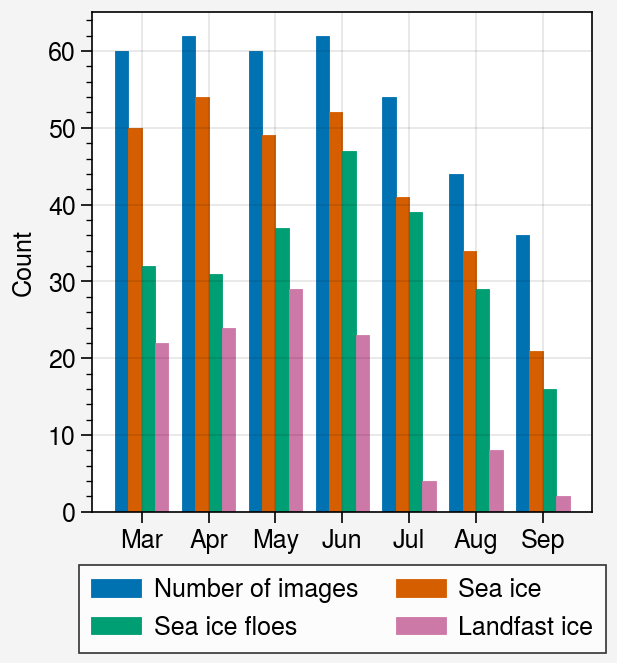

In [28]:
import proplot as pplt
fig, ax = pplt.subplots()

all_files = data.copy()
all_files['month'] = data['start_date'].dt.month
all_files.loc[:, 'visible_sea_ice'] = all_files.loc[:, 'visible_sea_ice'].where(all_files.loc[:, 'visible_sea_ice']=='yes')
all_files.loc[:, 'visible_landfast_ice'] = all_files.loc[:, 'visible_landfast_ice'].where(all_files.loc[:, 'visible_landfast_ice']=='yes')
all_files.loc[:, 'visible_floes'] = all_files.loc[:, 'visible_floes'].where(all_files.loc[:, 'visible_floes']=='yes')
all_files.rename({'cloud_fraction_manual': 'Number of images',
                  'visible_sea_ice': 'Sea ice',
                  'visible_floes': 'Sea ice floes',
                  'visible_landfast_ice': 'Landfast ice'}, axis=1, inplace=True)

ax.bar(all_files.loc[:, ['month', 'Number of images', 'Sea ice', 'Sea ice floes', 'Landfast ice']].groupby('month').count())
ax.legend(loc='b', ncols=2)
ax.format(ylabel='Count', xlabel='', xlocator=np.arange(3, 10),
          xformatter=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'],
          xtickminor=False)
fig.save('../figures/data_availability.png', dpi=300)